## Step 1: Dataset 및 Activation 함수 변경

Files already downloaded and verified
Files already downloaded and verified
torch.Size([256, 3, 32, 32]) torch.Size([256])


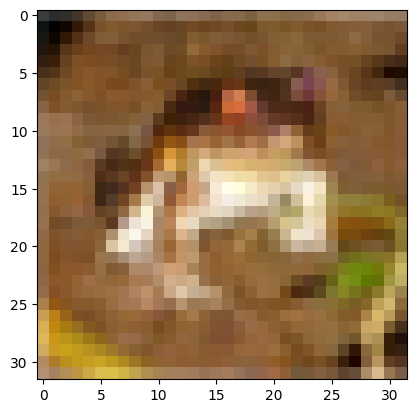

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim

# 1. Dataset 로딩 (CIFAR10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR10 데이터 정규화
])

# Train 데이터 로딩
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Test 데이터 로딩
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Train/Test 데이터 로더
batch_size = 256
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

# 데이터 형태 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)  # CIFAR10의 입력 shape 확인

# CIFAR10은 (3, 32, 32)의 shape을 가짐
plt.imshow(trainset[0][0].permute(1, 2, 0) * 0.5 + 0.5)  # 이미지 시각화
plt.show()


## Step 2: 모델 정의 (Activation 함수 LeakyReLU로 변경)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 채널 (RGB 이미지)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # CIFAR10은 (32x32)이므로 (64 * 8 * 8)로 변경
        self.fc2 = nn.Linear(128, 10)  # Output: 10 classes (CIFAR10)

    def forward(self, x):
        x = self.pool(nn.LeakyReLU()(self.conv1(x)))  # LeakyReLU 사용
        x = self.pool(nn.LeakyReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = nn.LeakyReLU()(self.fc1(x))
        x = self.fc2(x)  # No activation here, CrossEntropyLoss includes softmax
        return x

## Step 3: Optimizer 설정 및 SGD와 Adam 성능 비교

Epoch 1, Loss: 1.5516, Train Accuracy: 0.5594, Test Accuracy: 0.5442
Epoch 2, Loss: 1.0843, Train Accuracy: 0.6731, Test Accuracy: 0.6459
Epoch 3, Loss: 0.9270, Train Accuracy: 0.7204, Test Accuracy: 0.6682
Epoch 4, Loss: 0.8259, Train Accuracy: 0.7327, Test Accuracy: 0.6795
Epoch 5, Loss: 0.7451, Train Accuracy: 0.7543, Test Accuracy: 0.6814
Epoch 6, Loss: 0.6893, Train Accuracy: 0.7805, Test Accuracy: 0.6915
Epoch 7, Loss: 0.6265, Train Accuracy: 0.8175, Test Accuracy: 0.7108
Epoch 8, Loss: 0.5766, Train Accuracy: 0.8305, Test Accuracy: 0.7077
Epoch 9, Loss: 0.5259, Train Accuracy: 0.8480, Test Accuracy: 0.7114
Epoch 10, Loss: 0.4871, Train Accuracy: 0.8624, Test Accuracy: 0.7068
Epoch 11, Loss: 0.4333, Train Accuracy: 0.8872, Test Accuracy: 0.7096
Epoch 12, Loss: 0.3847, Train Accuracy: 0.8974, Test Accuracy: 0.7043
Epoch 13, Loss: 0.3538, Train Accuracy: 0.8992, Test Accuracy: 0.7024
Epoch 14, Loss: 0.3167, Train Accuracy: 0.9015, Test Accuracy: 0.6957
Epoch 15, Loss: 0.2766, Train

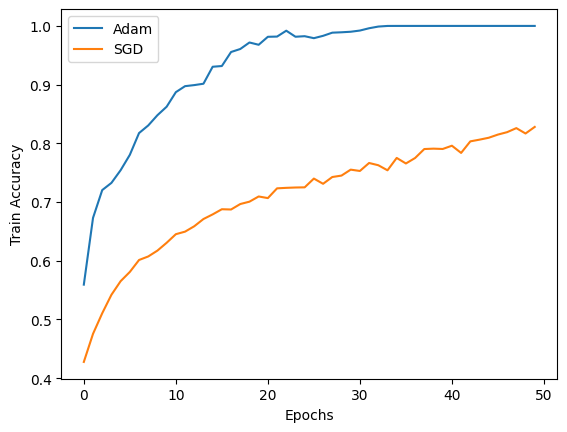

In [7]:
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch

# 모델 가중치 초기화 함수
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)  # He 초기화
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # bias 초기화

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드로 설정
    with torch.no_grad():  # Gradient 계산 안 함
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)  # 예측값의 인덱스 (클래스)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

def train_model(optimizer_name="adam"):
    # Optimizer 설정
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    n_epochs = 50
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()  # 학습 모드로 설정
        running_loss = 0.0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 매 에포크마다 train과 test 정확도 계산
        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, '
              f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_accuracies, test_accuracies

# Adam과 SGD 비교
model = Net().to('cuda')
loss_fn = nn.CrossEntropyLoss()

# Adam 옵티마이저로 학습
initialize_weights(model)  # 모델 가중치 초기화
adam_train_acc, adam_test_acc = train_model("adam")

# SGD 옵티마이저로 학습
initialize_weights(model)  # 모델 가중치 다시 초기화
sgd_train_acc, sgd_test_acc = train_model("sgd")

# Plot 1: SGD와 Adam 성능 비교
def plot_acc(train_acc1, train_acc2, label1='Adam', label2='SGD'):
    x = np.arange(len(train_acc1))

    plt.plot(x, train_acc1, label=label1)
    plt.plot(x, train_acc2, label=label2)
    plt.xlabel('Epochs')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

plot_acc(adam_train_acc, sgd_train_acc)

## Step 4: Leaky ReLU와 Sigmoid 성능 비교

Epoch 1, Loss: 1.5551, Train Accuracy: 0.5887, Test Accuracy: 0.5711
Epoch 2, Loss: 1.0904, Train Accuracy: 0.6657, Test Accuracy: 0.6310
Epoch 3, Loss: 0.9282, Train Accuracy: 0.7029, Test Accuracy: 0.6577
Epoch 4, Loss: 0.8319, Train Accuracy: 0.7486, Test Accuracy: 0.6880
Epoch 5, Loss: 0.7483, Train Accuracy: 0.7694, Test Accuracy: 0.6933
Epoch 6, Loss: 0.6809, Train Accuracy: 0.7936, Test Accuracy: 0.6915
Epoch 7, Loss: 0.6294, Train Accuracy: 0.8068, Test Accuracy: 0.6989
Epoch 8, Loss: 0.5682, Train Accuracy: 0.8365, Test Accuracy: 0.7092
Epoch 9, Loss: 0.5141, Train Accuracy: 0.8449, Test Accuracy: 0.7074
Epoch 10, Loss: 0.4638, Train Accuracy: 0.8669, Test Accuracy: 0.7085
Epoch 11, Loss: 0.4079, Train Accuracy: 0.8913, Test Accuracy: 0.7164
Epoch 12, Loss: 0.3695, Train Accuracy: 0.9037, Test Accuracy: 0.7090
Epoch 13, Loss: 0.3220, Train Accuracy: 0.9195, Test Accuracy: 0.7113
Epoch 14, Loss: 0.2761, Train Accuracy: 0.9280, Test Accuracy: 0.7046
Epoch 15, Loss: 0.2340, Train

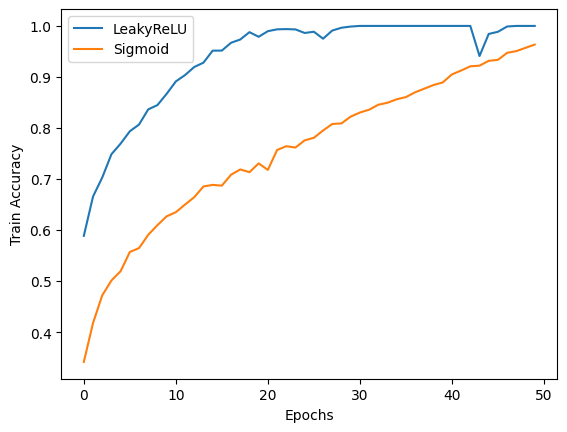

In [8]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch

# 모델 가중치 초기화 함수
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)  # He 초기화
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # bias 초기화

# LeakyReLU 모델 정의
class LeakyReLUNet(nn.Module):
    def __init__(self):
        super(LeakyReLUNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.LeakyReLU()(self.conv1(x)))
        x = self.pool(nn.LeakyReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.LeakyReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Sigmoid 모델 정의
class SigmoidNet(nn.Module):
    def __init__(self):
        super(SigmoidNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.Sigmoid()(self.conv1(x)))
        x = self.pool(nn.Sigmoid()(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.Sigmoid()(self.fc1(x))
        x = self.fc2(x)
        return x

def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    model.eval()  # 평가 모드로 설정
    with torch.no_grad():  # Gradient 계산 안 함
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)  # 예측값의 인덱스 (클래스)
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

def train_model(optimizer_name="adam", model=None):
    # Optimizer 설정
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    n_epochs = 50
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()  # 학습 모드로 설정
        running_loss = 0.0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 매 에포크마다 train과 test 정확도 계산
        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, '
              f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_accuracies, test_accuracies

# Leaky ReLU 모델 학습
model_leaky_relu = LeakyReLUNet().to('cuda')
loss_fn = nn.CrossEntropyLoss()
initialize_weights(model_leaky_relu)
leaky_relu_train_acc, _ = train_model("adam", model=model_leaky_relu)

# Sigmoid 모델 학습
model_sigmoid = SigmoidNet().to('cuda')
initialize_weights(model_sigmoid)
sigmoid_train_acc, _ = train_model("adam", model=model_sigmoid)

# Plot 2: Sigmoid와 Leaky ReLU 성능 비교
import matplotlib.pyplot as plt
def plot_acc(train_acc1, train_acc2, label1='LeakyReLU', label2='Sigmoid'):
    x = np.arange(len(train_acc1))

    plt.plot(x, train_acc1, label=label1)
    plt.plot(x, train_acc2, label=label2)
    plt.xlabel('Epochs')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

plot_acc(leaky_relu_train_acc, sigmoid_train_acc)

## Step 5: Dropout 적용 후 generalization error 확인

Epoch 1, Loss: 1.6081, Train Accuracy: 0.5791, Test Accuracy: 0.5608
Epoch 2, Loss: 1.1468, Train Accuracy: 0.6722, Test Accuracy: 0.6344
Epoch 3, Loss: 0.9673, Train Accuracy: 0.7103, Test Accuracy: 0.6574
Epoch 4, Loss: 0.8529, Train Accuracy: 0.7431, Test Accuracy: 0.6712
Epoch 5, Loss: 0.7649, Train Accuracy: 0.7846, Test Accuracy: 0.6914
Epoch 6, Loss: 0.6815, Train Accuracy: 0.8119, Test Accuracy: 0.6960
Epoch 7, Loss: 0.6226, Train Accuracy: 0.8410, Test Accuracy: 0.7023
Epoch 8, Loss: 0.5509, Train Accuracy: 0.8694, Test Accuracy: 0.7122
Epoch 9, Loss: 0.4928, Train Accuracy: 0.8828, Test Accuracy: 0.7077
Epoch 10, Loss: 0.4385, Train Accuracy: 0.9138, Test Accuracy: 0.7151
Epoch 11, Loss: 0.3851, Train Accuracy: 0.9256, Test Accuracy: 0.7110
Epoch 12, Loss: 0.3350, Train Accuracy: 0.9379, Test Accuracy: 0.7091
Epoch 13, Loss: 0.2912, Train Accuracy: 0.9510, Test Accuracy: 0.7055
Epoch 14, Loss: 0.2624, Train Accuracy: 0.9671, Test Accuracy: 0.7074
Epoch 15, Loss: 0.2229, Train

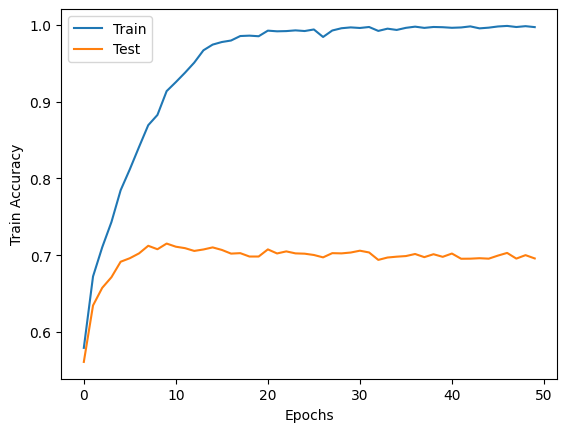

In [9]:
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.1)  # Dropout 적용

    def forward(self, x):
        x = self.pool(nn.LeakyReLU()(self.conv1(x)))
        x = self.pool(nn.LeakyReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(nn.LeakyReLU()(self.fc1(x)))  # Dropout 적용
        x = self.fc2(x)
        return x

# Dropout 모델 학습
model_dropout = DropoutNet().to('cuda')
initialize_weights(model_dropout)  # 가중치 초기화
dropout_train_acc, dropout_test_acc = train_model("adam", model=model_dropout)

# Plot 3: Dropout 적용 후 성능 비교
plot_acc(dropout_train_acc, dropout_test_acc, label1="Train", label2="Test")

## Step 6: 모델 예측과 실제 데이터 정답 체크

In [10]:
# Step 6: 모델 예측과 실제 정답 비교
model_dropout.eval()  # 평가 모드
correct = 0
total = 0

with torch.no_grad():  # 학습 모드가 아니므로 no_grad() 사용
    for idx in range(10):  # 처음 10개 데이터에 대해 예측
        image, label = testset[idx][0], testset[idx][1]  # 이미지와 실제 정답 가져오기
        image = image.unsqueeze(0).to('cuda')  # 배치 차원 추가 및 GPU로 이동

        output = model_dropout(image)  # 모델 예측
        pred = torch.argmax(output, dim=1).item()  # 예측값 추출

        # 예측값과 실제 레이블 비교
        correct_prediction = (pred == label)
        result = "맞았습니다!" if correct_prediction else "틀렸습니다."

        # 결과 출력
        print(f'이미지 {idx + 1}: 모델 예측 = {pred}, 실제 정답 = {label} ({result})')

        # 정확도 계산용
        if correct_prediction:
            correct += 1
        total += 1

print(f"\n처음 10개 이미지에서 모델의 정확도: {correct}/{total}")

이미지 1: 모델 예측 = 3, 실제 정답 = 3 (맞았습니다!)
이미지 2: 모델 예측 = 8, 실제 정답 = 8 (맞았습니다!)
이미지 3: 모델 예측 = 8, 실제 정답 = 8 (맞았습니다!)
이미지 4: 모델 예측 = 0, 실제 정답 = 0 (맞았습니다!)
이미지 5: 모델 예측 = 6, 실제 정답 = 6 (맞았습니다!)
이미지 6: 모델 예측 = 6, 실제 정답 = 6 (맞았습니다!)
이미지 7: 모델 예측 = 1, 실제 정답 = 1 (맞았습니다!)
이미지 8: 모델 예측 = 2, 실제 정답 = 6 (틀렸습니다.)
이미지 9: 모델 예측 = 3, 실제 정답 = 3 (맞았습니다!)
이미지 10: 모델 예측 = 1, 실제 정답 = 1 (맞았습니다!)

처음 10개 이미지에서 모델의 정확도: 9/10
